# Extracting color from an image (theory)

This program takes an image as an input and attempts to extract a good looking color from that image which can be used to as an accent color for the UI surrounding the image.<br/>
<br/>
Here are the steps:<br/>
<br/>

### Step 1: Weighted average of colors
To compute the average color of the image or a part of the image, we used weighted average.<br/>
<br/>
A pixels weight is computed by two values:
- How close it is to 50% luminacnce (that is, give lesser weight to pixels that are too bright or too dark).
- How vibrant the pixel is (more saturation gets more weight)<br/><br/>
(We can control the effect of luminance and saturation using parameters listed below).<br/>
<br/>

### Step 2: Swatches
This is most of simple of the steps. It is essentially, breaking down of the image in n x n, sub-images, and then computing weighted average of each sub-iamge individually.<br/>
(We also compute the weighted average of all swatches, this is later used to compute most frequently seen color).<br/>
<br/>

### Step 3: Selecting best swatch
Once we have the list of swatches, (and their average), we compute following 3 values:
- **L_factor**: This value gives us how close a swatch is to 50% luminance
- **S_factor**: This value computes how vibrant a swatch is (multplied by a power of L_factor to avoid giving too much attention to too dark or too bright colors which have high saturation).
- **D_factor**: Computes how close the hue of the color is to the overall average of all swatches. (It essentially tells how dominant a color is in the image).<br/><br/>
These three values are then combined in a single value using the function `f1` which simply computes parametered sum of these 3 values.<br/>
<br/>

### Step 4: Transformation
Once we have the best swatch color, the final output can be manipulated in any way possible. We here present the option to select the luminance range, and saturation multiplier. These settings should enable the selected color to blend-in with the UI.


# Parameters
<br />

##### No. of swatches
`n` = No. of swatches made are n x n<br />
<br />

##### Parameters used for calculating average color of pixels (ranging from 0.0 to1.0)
`avg_s_weight` = Weight given to saturation of a pixel when calculating average color<br />
\* Pixel with 50% luminance gets highest weight.<br />
`avg_l_weight` = Weight given to luminance of a pixel when calculating average color *<br />
<br />
##### Parameters used for choosing best-swatch (ranging from 0.0 to1.0)
`L_weight` = Weight given to brightness/luminance of a swatch when choosing best swatch<br />
\* Swatch with 50% luminance gets highest preference.<br />
`S_weight` = Weight given to saturation of a swatch when choosing best swatch<br />
`D_weight` = Weight given to the dominance of a swatch when choosing best swatch<br />
\* Dominance measures how close a swatch is to average color (how dominant a color is)<br />
<br />
##### Parameters used for transforming best-swatch to output
`L_min_threshold` = Min. luminance required for output color (0 - 255)<br />
`L_max_threshold` = Max. luminance required for output color (0 - 255)<br />
`S_value` = Saturation multiplier for output color (0.0 - 1.0)<br />

**Note:** Place your images in `albumarts` folder (create the folder if not present). Set the img_name to the sample image you want to test

In [1]:
import numpy as np
import math
from utils import display,compare,hls2rgb,read_image_hls
import os

%matplotlib inline

In [2]:
n = 12 # no. of swatches

# Parameters for averaging
avg_s_weight = 0.3 # weight given to saturation of a color when computing averages
avg_l_weight = 0.7 # weight given to luminance (50% means highest) of a color when computing averages

# Parameters for choosing best-swatch
L_weight = 0.2
S_weight = 0.6
D_weight = 0.2

# Parameters used while transforming
L_min_threshold = 48
L_max_threshold = 128
S_value = 1.0

In [3]:
sample_dir = 'albumarts/' # directory where test iamges are stored
img_name = "art-1.png"
test_image_path = sample_dir + img_name

# Average Color

In [4]:
def get_weights(hls_image, w_s = avg_s_weight, w_l = avg_l_weight):
    l_weights = (w_l * (1. - abs(hls_image[:,:,1] - 127.5) / 127.5))
    s_weights = (w_s * (hls_image[:,:,2] / 255))
    weights = l_weights + s_weights + (1 - (w_l + w_s)/2)
    return weights

In [5]:
def get_weighted_average_color(hls_image, w_s = avg_s_weight, w_l = avg_l_weight, EPSILON = 10e-6):
    weights = get_weights(hls_image, w_s=w_s, w_l=w_l)
    A1 = hls_image * weights[..., np.newaxis]
    A2 = np.sum(A1, axis=0)
    A3 = np.sum(A2, axis=0)
    A4 = A3 / (np.sum(weights) + EPSILON)
    return A4.reshape(1,1,3).astype('uint8')

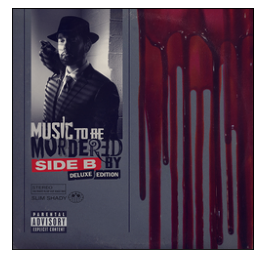

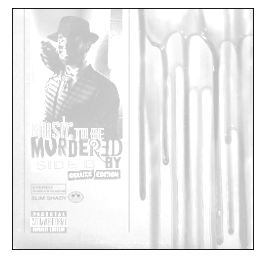

<Figure size 432x288 with 0 Axes>

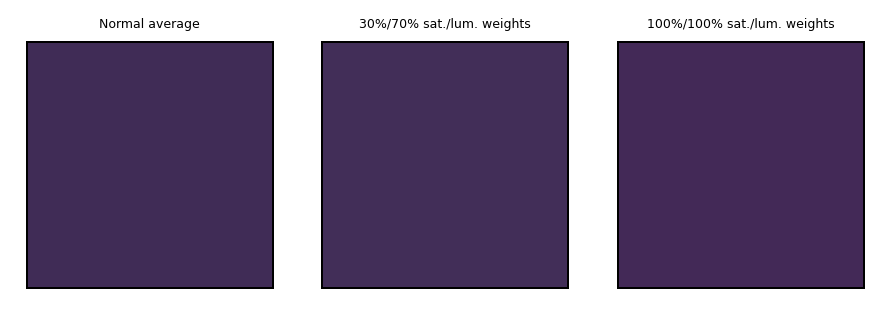

In [6]:
test_image_hls = read_image_hls(test_image_path)

display(hls2rgb(test_image_hls), dpi=80)
display(get_weights(test_image_hls), cmap="gray", vmin=0., vmax=1., dpi=80)

i0  = hls2rgb(get_weighted_average_color(test_image_hls, w_s=0, w_l=0))
i70 = hls2rgb(get_weighted_average_color(test_image_hls, w_s=0.3, w_l=0.7))
i100 = hls2rgb(get_weighted_average_color(test_image_hls, w_s=1., w_l=1.))

compare([i0, i70, i100], labels=["Normal average", "30%/70% sat./lum. weights", "100%/100% sat./lum. weights"])

# Swatches

In [7]:
def get_swatches(hls_image, num_swatches):
    s = num_swatches
    image = hls_image
    
    EPSILON = 10e-6
    
    width = image.shape[1]
    height = image.shape[0]
    
    base_w = math.floor(width / s)
    base_h = math.floor(height / s)

    boxes = []

    for row in range(s):
        for col in range(s):
            base_w_adjusted = math.ceil(width / s) if (col + 1 == s) else base_w
            base_h_adjusted = math.ceil(height / s) if (row + 1 == s) else base_h

            slice_w = slice(col * base_w, (col + 1) * base_w_adjusted)
            slice_h = slice(row * base_h, (row + 1) * base_h_adjusted)

            boxes.append(image[slice_h, slice_w, :])
    
    swatches = np.array([]).reshape(0).astype('uint8')
    
    for b in boxes:
        swatch_color = get_weighted_average_color(b).reshape(3)
        swatches = np.append(swatches, swatch_color, axis=0)

    swatches = swatches.reshape(s, s, 3).astype('uint8')
    
    return swatches


<Figure size 432x288 with 0 Axes>

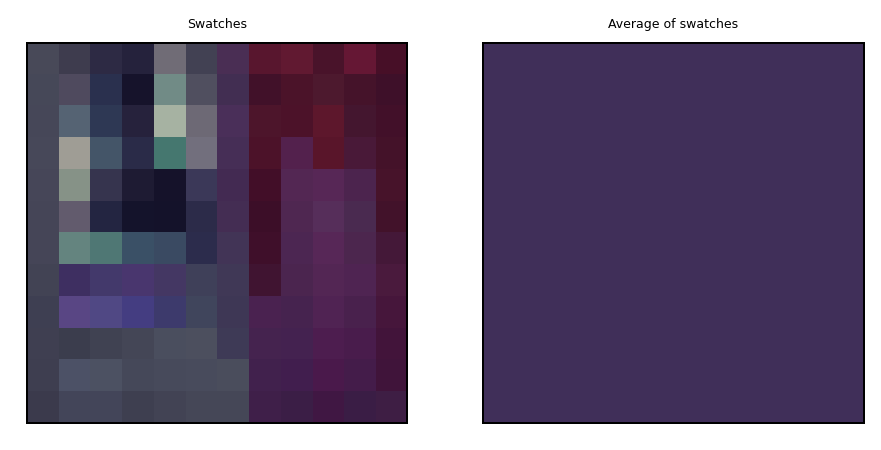

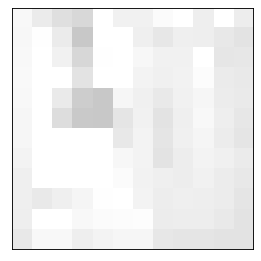

In [8]:
test_hls = read_image_hls(test_image_path)
test_swatches = get_swatches(test_hls, n)

compare([hls2rgb(test_swatches), hls2rgb(get_weighted_average_color(test_swatches))], labels=["Swatches", "Average of swatches"])
display(get_weights(test_swatches), cmap="gray", vmin=0., vmax=1., dpi=80)

# Best swatch

In [9]:
def f1(L, S, D):
    return (L_weight * L) + (S_weight * S) + (D_weight * D)

In [10]:
def get_best_swatch(swatches):
    s = swatches.shape[0]
    avg_color = get_weighted_average_color(swatches).reshape(3)
    
    EPSILON = 10e-6
    
    max_value = 0
    best_swatch = np.array([0, 0, 0])

    for row in range(s):
        for col in range(s):
            swatch = swatches[row][col]
            H,L,S = swatch
            
            # puts penalty if color is too bright or too dark
            L_factor = 1. - (abs(L - 127.5) / 127.5)
            
            # encourages vibrant colors
            S_factor = L_factor**L_weight * S / 255
            
            # prefers color which is more dominant (closer to average color)
            D_factor = 1. - (abs(H.astype('int16') - avg_color[0]) / 255)

            value = f1(L_factor, S_factor, D_factor)

            if (value > max_value):
                best_swatch = swatch
                max_value = value

    best_swatch = best_swatch.reshape(1, 1, 3).astype('uint8')
    
    return best_swatch


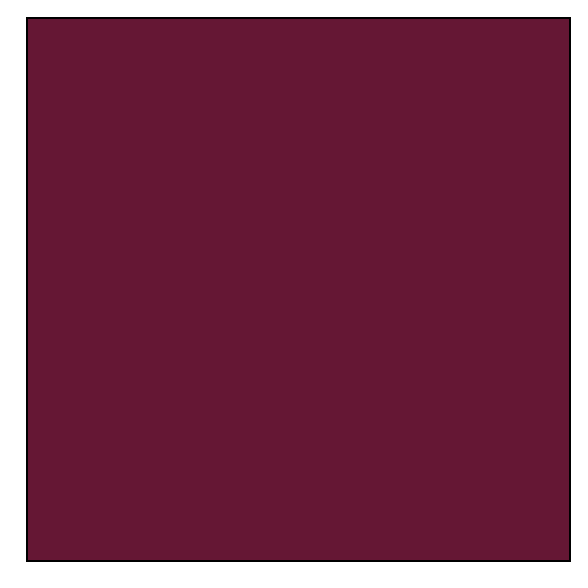

In [11]:
test_best_swatch = get_best_swatch(test_swatches)
display(hls2rgb(test_best_swatch))

# Transformation

In [12]:
def get_transformed_color(best_swatch):
    H,L,S = best_swatch.reshape(3,)
    
    # use same hue as original color
    H1 = H
    
    # transform 0-255 luminance range to parameterd min-max range
    L_hat = L_min_threshold + (L_max_threshold - L_min_threshold) * (L / 255)
    
    # prefer original luminance if saturation is very high
    # otherwise prefer the transformed luminance value, for duller colors
    L1 = (1 - S/255) * (L_hat) + (S/255)*(L)
    
    # transform saturation (multiply by some factor)
    S1 = min(255, S * S_value)

    picked_color = np.array([H1, L1, S1]).reshape(1,1,3).astype('uint8')
    
    return picked_color

In [13]:
test_output_color = get_transformed_color(test_best_swatch)

Best swatch (HLS): [[[169  62 161]]]
Final output (HLS): [[[169  64 161]]]


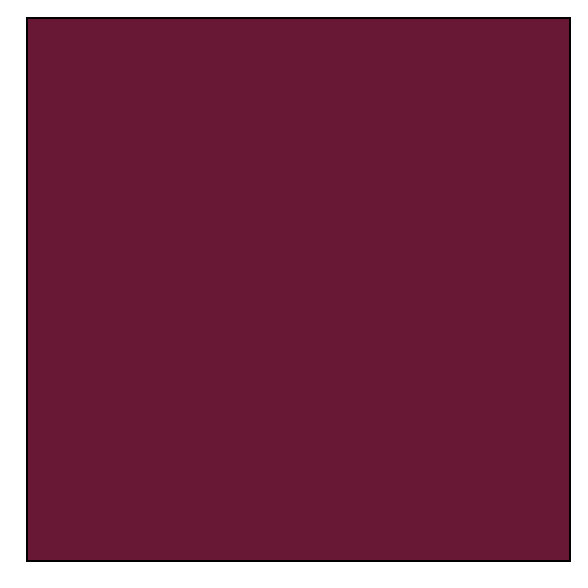

In [14]:
print(f"Best swatch (HLS): {test_best_swatch}")
print(f"Final output (HLS): {test_output_color}")
display(hls2rgb(test_output_color))

# Testing

In [17]:
files = map(lambda file: file.name, filter(lambda file: file.is_file(), os.scandir(sample_dir)))
print(list(files))

In [16]:
for file in files:
    image = read_image_hls(file)
    swatches = get_swatches(image, n)
    best_swatch = get_best_swatch(swatches)
    picked_color = get_transformed_color(best_swatch)
    picked_color_rgb = hls2rgb(picked_color)
    
    compare([hls2rgb(image), picked_color_rgb])

error: OpenCV(4.5.4) /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-f8yjfelj/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
